In [20]:
# reload magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Import deterministic.py using local file path
import sys

import numpy as np
import torch
from torch.nn import functional as F
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
import matplotlib.pyplot as plt

from torchdistill.core.forward_hook import ForwardHookManager

sys.path.append('../sequence_generators')
import deterministic
sys.path.append('../ucan')
import ucan
import ucan_transformer



#### UCAN dataset

The UCAN dataset has inputs $(Y \oplus \Gamma, \Delta)$, targets $Y$, and 'hidden variable' $\Gamma$, all of which are length-n bitstrings. Note that I'm changing my notation from whats in the writeup to match input/target sequence labels better.

This has to be done in a few steps:
1. Generate a dataset for $Y$, array $(n_{data}, n)$
2. Generate a matched dataset $(\Gamma, \Delta)$, array $(N, n, 2)$ for whatever version of UCAN
3. Compose and discard, i.e. $X = Y \oplus \Gamma$, data = $[Z, \Delta]$ array $(N, 2n)$

In [22]:
# Get a deterministic set of sequences of length N_BITS
# with the sos and eos tokens, this becomes length 2 + 2N_BITS
# This is why the number of bits looks funny
data = [[0,0], [0,1], [1,0], [1,1]]
X = np.array(data, dtype=np.int32)
Y = np.array([(2, 0), (2, 1), (2, 1), (2, 0)], dtype=np.int32)

data = torch.tensor(X).type(torch.LongTensor) # (n_data, 2)
targets = torch.tensor(Y).type(torch.LongTensor) # (n_data)

print("Shape of input data: ", data.shape)
print("Shape of output data: ", targets.shape)

train_data = data
train_targets = targets

batch_size = 4 
def get_batch(split):
    return train_data.to(DEVICE), train_targets.to(DEVICE)

Shape of input data:  torch.Size([4, 2])
Shape of output data:  torch.Size([4, 2])


In [27]:
# Training deck

num_encoder_layers = 1
num_decoder_layers = 1
emb_size = 2
nhead = 1
src_vocab_size = 2
tgt_vocab_size = 3
dim_feedforward = 2
# For deterministic task, dropout doesn't make sense
dropout = 0.0

# hyperparameters
eval_iters = 1
LEARNING_RATE = 0.0001

# Train loop
eval_interval = 200
max_iters = 20000



In [216]:

model = ucan_transformer.Seq2SeqTransformer(
    num_encoder_layers, 
    num_decoder_layers, 
    emb_size, 
    nhead, 
    src_vocab_size, 
    tgt_vocab_size, 
    dim_feedforward, 
    positional_encoding=False,
    norm_first=False,
    dropout=dropout
).to(DEVICE)
# `forward` signature: (src, trg, src_mask, tgt_mask, **kwargs)

torch.manual_seed(0)
z = 1e5 # large number.
# Using the names of parameters in the above output:
# set the decoder linear bias to zero, and linear weights to identity
# and disable the learning of these parameters
for name, param in model.named_parameters():

    # set the encoder query and key matrices to all ones and disable learning
    # ENCODER SELF-ATTENTION MODIFICATIONS
    if name == 'src_tok_emb.embedding.weight':
        param.requires_grad = False
        param.fill_(0)
        param[0,0] = 1 / np.sqrt(2)
        param[1,1] = 1 / np.sqrt(2)
        
    if name == 'transformer.encoder.layers.0.self_attn.in_proj_weight':
        param.requires_grad = False
        assert model.transformer.encoder.layers[0].self_attn._qkv_same_embed_dim

        W_q = z*np.array([[0, 1], [1, 0]])
        W_k = np.eye(2)
        # W_v = np.arange(4).reshape((2,2)).T
        W_v = np.eye(2)

        param[:2] = torch.tensor(W_q, dtype=torch.float32).to(DEVICE)      
        param[2:2*2] = torch.tensor(W_k, dtype=torch.float32).to(DEVICE)     
        param[2*2:] = torch.tensor(W_v.T, dtype=torch.float32).to(DEVICE)    

    if name == 'transformer.encoder.layers.0.self_attn.in_proj_bias':
        param.requires_grad = False
        param.fill_(0)
    # set the encoder out_proj_weight to identity and disable learning
    if name == 'transformer.encoder.layers.0.self_attn.out_proj.weight':
        param.requires_grad = False
        param.fill_(0)
        param[0,0] = 1
        param[1,1] = 1
    # set the encoder out_proj_bias to zero and disable learning
    if name == 'transformer.encoder.layers.0.self_attn.out_proj.bias':
        param.requires_grad = False
        param.fill_(0)
    
    # ENCODER FFN MODIFICATIONS
    # Set the encoder linear weights to identity and disable learning
    if name == 'transformer.encoder.layers.0.linear1.weight':
        param.requires_grad = False
        param.fill_(0)
        param[0,0] = 1
        param[1,1] = 1

    # set the encoder linear bias to zero and disable learning
    if name == 'transformer.encoder.layers.0.linear1.bias':
        param.requires_grad = False
        param.fill_(0)
    # set the encoder linear2 weight to ((100, 0), (100, 0)) and disable learning
    if name == 'transformer.encoder.layers.0.linear2.weight':
        param.requires_grad = False
        param.fill_(0)
        # NOTE: The weights are transposed in defintiion of Linear
        param[0,0] = z
        param[0,1] = z
    # set the encoder linear2 bias to zero and disable learning
    if name == 'transformer.encoder.layers.0.linear2.bias':
        param.requires_grad = False
        param.fill_(0)
        param[0] = -z/2
    
    # DECODER SELF-ATTENTION MODIFICATIONS
    # set decoder embedding to identity and disable learning
    if name == 'tgt_tok_emb.embedding.weight':
        param.requires_grad = False
        param.fill_(0)
    if name == 'transformer.decoder.layers.0.self_attn.in_proj_weight':
        param.requires_grad = False
        param.fill_(0)
    if name == 'transformer.decoder.layers.0.self_attn.in_proj_bias':
        param.requires_grad = False
        param.fill_(0)
    # set decoder out_proj_weight to identity and disable learning
    if name == 'transformer.decoder.layers.0.self_attn.out_proj.weight':
        param.requires_grad = False
        param.fill_(0)
        param[0,0] = 1
        param[1,1] = 1
    # set decoder out_proj_bias to zero and disable learning
    if name == 'transformer.decoder.layers.0.self_attn.out_proj.bias':
        param.requires_grad = False
        param.fill_(0)
    if name == 'transformer.decoder.layers.0.linear1.bias':
        param.requires_grad = False
        param.fill_(0)
    if name == 'transformer.decoder.layers.0.linear1.weight':
        param.requires_grad = False
        param.fill_(0)
        param[0,0] = 1
        param[1,1] = 1

    # set the multihead attention in_proj_weight to ((100, 0), (100, 0)) and disable learning
    if name == 'transformer.decoder.layers.0.multihead_attn.in_proj_weight':
        param.requires_grad = False
        W_q = np.zeros((2, 2))
        W_k = np.zeros((2, 2))
        W_v = np.eye(2)

        param[:2] = torch.tensor(W_q, dtype=torch.float32).to(DEVICE)      
        param[2:2*2] = torch.tensor(W_k, dtype=torch.float32).to(DEVICE)     
        param[2*2:] = torch.tensor(W_v.T, dtype=torch.float32).to(DEVICE)    

    if name == 'transformer.decoder.layers.0.linear2.bias':
        param.requires_grad = False
        param.fill_(0)
    if name == 'transformer.decoder.layers.0.linear2.weight':
        param.requires_grad = False
        param.fill_(0)
        param[0,0] = 1
        param[1,1] = 1

# Assuming you have a model called 'model'
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

# transformer.decoder.layers.0.self_attn.in_proj_weight False
# transformer.decoder.layers.0.self_attn.in_proj_bias False
# transformer.decoder.layers.0.self_attn.out_proj.weight True
# transformer.decoder.layers.0.self_attn.out_proj.bias True
# transformer.decoder.layers.0.multihead_attn.in_proj_weight True
# transformer.decoder.layers.0.multihead_attn.in_proj_bias True
# transformer.decoder.layers.0.multihead_attn.out_proj.weight True
# transformer.decoder.layers.0.multihead_attn.out_proj.bias True

Total trainable parameters: 49


c:\Users\peter\Desktop\projects\MindReadingAutobot\.venv\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [217]:
model.eval()

tgt_mask = ucan_transformer.generate_square_subsequent_mask(1, device=DEVICE)
src_mask = None
split = 'train'
X, Y = get_batch(split)
tgt_input = Y[:, :-1]
tgt_out = Y[:, 1:]


forward_hook_manager = ForwardHookManager(DEVICE)
ENC_HOOKS = [
    'src_tok_emb.embedding',
    'transformer.encoder.layers.0.self_attn',
    'transformer.encoder.layers.0.norm1',
    'transformer.encoder.layers.0.linear1',
    'transformer.encoder.layers.0.linear2',
    'transformer.encoder.layers.0.norm2',
]

DEC_HOOKS = [
    'transformer.decoder.layers.0.self_attn',
    'transformer.decoder.layers.0.norm1',
    'transformer.decoder.layers.0.multihead_attn',
    'transformer.decoder.layers.0.norm2',
    'transformer.decoder.layers.0.linear1',
    'transformer.decoder.layers.0.linear2',
    'generator'
]
for hook in ENC_HOOKS + DEC_HOOKS:
    forward_hook_manager.add_hook(model, hook, requires_input=True, requires_output=True)


for i in range(4):
    # if i != 1:
    #     continue
    x = X[i,:]
    # run the model and sink the hooks
    output = model(x, tgt_input[i], src_mask, tgt_mask)
    io_dict = forward_hook_manager.pop_io_dict()
    assert(torch.equal(x, io_dict.get('src_tok_emb.embedding').get('input')))

    print(x)    
    print(tgt_out[i])
    # for hook in ENC_HOOKS:
    #     print(hook)
    #     # print(io_dict.get(hook).get('input'))
    #     print(io_dict.get(hook).get('output'))
    #     print()
    # break
    for hook in DEC_HOOKS:
        if hook == 'generator':
            print(hook)
            print("INPUTS", io_dict.get(hook).get('input'))
            print(io_dict.get(hook).get('output'))
            print()


    # print(activation['transformer.encoder.layers.0.self_attn.in_proj_weight'])
    # print(activation['src_tok_emb.embedding'])
    # print(activation['transformer.encoder.layers.0.linear1'])
    # print(activation['transformer.encoder.layers.0.dropout1'])
    # print(activation['transformer.encoder.layers.0.linear2'])
    print()

tensor([0, 0])
tensor([0])
generator
INPUTS tensor([[[ 1.0000, -1.0000]]], grad_fn=<NativeLayerNormBackward0>)
tensor([[[-0.6604, -0.1675,  0.0343]]], grad_fn=<ViewBackward0>)


tensor([0, 1])
tensor([1])
generator
INPUTS tensor([[[-1.0000,  1.0000]]], grad_fn=<NativeLayerNormBackward0>)
tensor([[[-0.6125,  0.0721,  1.2094]]], grad_fn=<ViewBackward0>)


tensor([1, 0])
tensor([1])
generator
INPUTS tensor([[[-1.0000,  1.0000]]], grad_fn=<NativeLayerNormBackward0>)
tensor([[[-0.6125,  0.0721,  1.2094]]], grad_fn=<ViewBackward0>)


tensor([1, 1])
tensor([0])
generator
INPUTS tensor([[[ 1.0000, -1.0000]]], grad_fn=<NativeLayerNormBackward0>)
tensor([[[-0.6604, -0.1675,  0.0343]]], grad_fn=<ViewBackward0>)




In [210]:

# Image Example
for X in [np.array([[1, 0], [1, 0]]), np.array([[1, 0], [0, 1]]), np.array([[0, 1], [1, 0]]), np.array([[0, 1], [0, 1]])]:
    X = torch.tensor(X, dtype=torch.float).to(DEVICE)

    # Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
    # as shown in the image below
    layer_norm = torch.nn.LayerNorm([2, 2])
    output = layer_norm(X + X)
    print(output)

tensor([[ 1.0000, -1.0000],
        [ 1.0000, -1.0000]], grad_fn=<NativeLayerNormBackward0>)
tensor([[ 1.0000, -1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>)
tensor([[-1.0000,  1.0000],
        [ 1.0000, -1.0000]], grad_fn=<NativeLayerNormBackward0>)
tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>)


In [218]:
def make_src_mask(n):
    return None

N_BITS = 1

@torch.no_grad()
def estimate_loss(verbose=False):
    # Average the loss over many batches. Hardcoded cross_entropy loss
    # Needs to be in same namespace as model and get_batch
    out = {}
    model.eval()
    tgt_mask = ucan_transformer.generate_square_subsequent_mask(N_BITS, device=DEVICE)
    src_mask = make_src_mask(N_BITS)
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            tgt_input = Y[:, :-1]
            tgt_out = Y[:, 1:]
            logits = model(X, tgt_input, src_mask, tgt_mask)

            if verbose:
                preds = torch.argmax(logits.reshape(batch_size, N_BITS, tgt_vocab_size), dim=2)
                for i in range(len(X)):
                    print(f"input: {X[i]}")
                    print(f"target: {tgt_out[i]}")
                    print(f"predicted: {preds[i]}")
                    print(logits.reshape(batch_size, N_BITS, tgt_vocab_size)[i])
                    print()
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [219]:

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

loss_history = []

memory = model.encode(X, None)
print(memory)
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')
    # we're doing that kind of sketchy off-by-one thing
    # the input is missing the final token (it's always the EOS token....)
    tgt_input = yb[:, :-1]
    tgt_mask = ucan_transformer.generate_square_subsequent_mask(tgt_input.size(1), device=DEVICE)
    src_mask = make_src_mask(N_BITS)
    logits = model(xb, tgt_input, src_mask, tgt_mask)

    # and the loss is based on the output, which is missing the first token (it's always the SOS token....)
    tgt_out = yb[:, 1:]
    loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    loss_history.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()



tensor([[[ 1.0000, -1.0000],
         [ 1.0000, -1.0000]],

        [[-1.0000,  1.0000],
         [-1.0000,  1.0000]],

        [[-1.0000,  1.0000],
         [-1.0000,  1.0000]],

        [[ 1.0000, -1.0000],
         [ 1.0000, -1.0000]]], grad_fn=<NativeLayerNormBackward0>)
step 0: train loss 1.5329, val loss 1.5329
step 200: train loss 1.4484, val loss 1.4484
step 400: train loss 1.3673, val loss 1.3673
step 600: train loss 1.2893, val loss 1.2893
step 800: train loss 1.2143, val loss 1.2143
step 1000: train loss 1.1423, val loss 1.1423
step 1200: train loss 1.0733, val loss 1.0733
step 1400: train loss 1.0070, val loss 1.0070
step 1600: train loss 0.9436, val loss 0.9436
step 1800: train loss 0.8828, val loss 0.8828
step 2000: train loss 0.8247, val loss 0.8247
step 2200: train loss 0.7693, val loss 0.7693
step 2400: train loss 0.7164, val loss 0.7164
step 2600: train loss 0.6660, val loss 0.6660
step 2800: train loss 0.6182, val loss 0.6182
step 3000: train loss 0.5728, val loss 0.

In [220]:
estimate_loss(verbose=True)


input: tensor([0, 0])
target: tensor([0])
predicted: tensor([0])
tensor([[ 6.1308, -3.3359, -3.3516]])

input: tensor([0, 1])
target: tensor([1])
predicted: tensor([1])
tensor([[-3.1588,  6.4066, -2.2733]])

input: tensor([1, 0])
target: tensor([1])
predicted: tensor([1])
tensor([[-3.1588,  6.4066, -2.2733]])

input: tensor([1, 1])
target: tensor([0])
predicted: tensor([0])
tensor([[ 6.1308, -3.3359, -3.3516]])

input: tensor([0, 0])
target: tensor([0])
predicted: tensor([0])
tensor([[ 6.1308, -3.3359, -3.3516]])

input: tensor([0, 1])
target: tensor([1])
predicted: tensor([1])
tensor([[-3.1588,  6.4066, -2.2733]])

input: tensor([1, 0])
target: tensor([1])
predicted: tensor([1])
tensor([[-3.1588,  6.4066, -2.2733]])

input: tensor([1, 1])
target: tensor([0])
predicted: tensor([0])
tensor([[ 6.1308, -3.3359, -3.3516]])



{'train': tensor(0.0002), 'val': tensor(0.0002)}

#### Log

Enc |dec | dmodel | nhead | dim_ff | final train/val loss
8,4,16,4,128 .21 / .16



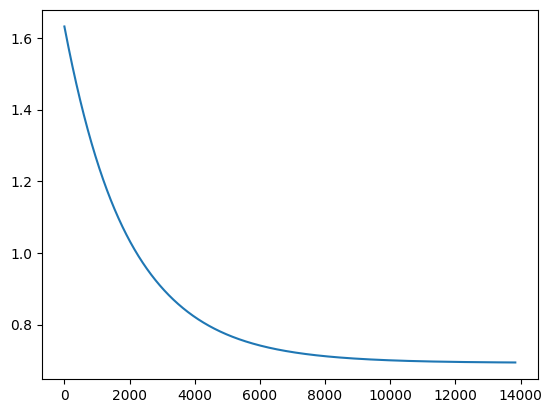

In [137]:

plt.plot(loss_history)

In [52]:
model.eval()
# sample a batch of data
torch.manual_seed(1337) # to get what andrej karpathy got
xb, yb = get_batch('train')

for i in range(batch_size):
    x, y = xb[i], yb[i]
    print(x.shape)
    x, y = x.unsqueeze(0), y.unsqueeze(0)
    print(x.shape)
    break

    src_mask = make_src_mask(N_BITS)
    tgt_mask = ucan_transformer.generate_square_subsequent_mask(N_BITS + 2, device=DEVICE)
    # evaluate the loss
    logits = model(x, y, src_mask, tgt_mask)
    print('logits:', logits.shape)
    print('loss:', loss)

    # sample the output from the logits
    _, preds = torch.max(logits, dim=1)
    print("x    ", x.squeeze(0))
    print("logits", logits)
    print("preds", preds)
    print("y    ", y.squeeze(0))
    print()

# -----------------------------------------------
# GENERATING SEQUENCES
max_len = N_BITS + 2

for i in range(batch_size):
    x, y = xb[i], yb[i]
    x, y = x.unsqueeze(0), y.unsqueeze(0)
    src_mask = make_src_mask(N_BITS)

    memory = model.encode(x, src_mask).to(DEVICE) # now this is phi(x), shape (1, 2*N_BITS + 2, emb_dim)
    ys = torch.ones(1, 1).fill_(SOS_TOKEN).type(torch.long).to(DEVICE)


    print("input", x)
    print("target", y)
    for i in range(max_len - 1): # -1 since we start with SOS
        tgt_mask = (ucan_transformer.generate_square_subsequent_mask(ys.size(1), device=DEVICE).type(torch.bool)).to(DEVICE) 
        out = model.decode(tgt=ys, memory=memory, tgt_mask=tgt_mask) # (1, tgt_seq_len, emb_dim)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(x.data).fill_(next_word)], dim=1)
        # print(out, "out")
        # print(ys, "ys")
        # print(prob, "prob")
        # print()
    print("final output", ys)
    print()


# tgt_mask = (ucan_transformer.generate_square_subsequent_mask(ys.size(1), device=DEVICE).type(torch.bool)).to(DEVICE) 

# # This mask sets -inf to True, which is correct according to `Transformer` docs
# i = 0
# out = model.decode(tgt=ys, memory=memory, tgt_mask=tgt_mask) # (1, tgt_seq_len, emb_dim)
# print("out.shape", out.shape)
# logits = model.generator(out[:, -1])
# # logits = model.generator(out)
# print("logits.shape", logits.shape)

# _, preds = torch.max(logits, dim=-1)
# print("ys  ", ys)
# print("pred:", preds)

# print(memory)



torch.Size([2])
torch.Size([1, 2])


NameError: name 'SOS_TOKEN' is not defined

In [15]:
xv, yv = get_batch('val')
src = xv[0]
truth = yv[0]

src = src.to(DEVICE)
src_mask = None
max_len = 10

# For a single example evaluation, we need to add a dummy batch dimension (1, *) with unsqueeze(0)
memory = model.encode(src.unsqueeze(0), src_mask)
# The [1, 1] shape starts us off with a dummy batch dimension 
ys = torch.ones(1, 1).fill_(SOS_TOKEN).type(torch.long).to(DEVICE)

print(memory)

for i in range(max_len - 1): # -1 since we start with SOS
    memory = memory.to(DEVICE)
    tgt_mask = (ucan_transformer.generate_square_subsequent_mask(ys.size(1), device=DEVICE)).to(DEVICE)
    print(tgt_mask)
    out = model.decode(tgt=ys, memory=memory, tgt_mask=tgt_mask) # (1, tgt_seq_len, emb_dim)


    prob = model.generator(out[:, -1])
    print(out, "out")
    print(ys, "ys")
    print(prob, "prob")
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.item()
    ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    print()


tensor([[[-2.7868,  0.3571,  0.2683, -0.3423,  0.8015,  0.9599, -0.7208,
           0.0275,  0.1133,  0.3672, -0.5141,  1.3417],
         [-1.1109,  0.3338,  0.3859, -1.4481, -0.9562,  2.0624,  1.2049,
          -0.6362,  0.2811,  0.6141, -0.8774,  0.0184],
         [-1.1241,  0.2551,  0.4137, -1.4547, -0.9476,  2.0578,  1.2247,
          -0.6118,  0.2941,  0.6032, -0.8785,  0.0387],
         [-1.1677,  0.2572,  0.3904, -1.4032, -0.9617,  2.0293,  1.3103,
          -0.5942,  0.2802,  0.5733, -0.8782,  0.0352],
         [-1.2104,  0.3464,  0.3609, -1.3546, -0.9713,  1.9936,  1.3736,
          -0.5989,  0.2561,  0.5441, -0.8755,  0.0084],
         [-1.9315, -0.6380,  1.4399,  0.3022,  1.0120,  0.4055, -1.1799,
           0.0860, -0.1640,  0.7048, -1.2249,  1.0884],
         [-1.9339, -0.5638,  1.4427,  0.2349,  1.0007,  0.4492, -1.2247,
           0.1311, -0.1612,  0.6739, -1.2345,  1.0857],
         [-1.1189,  0.3520,  0.4719, -1.5429, -0.8868,  2.0529,  1.1527,
          -0.6148,  0.27

In [101]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len):
    """Standard autoregressive decoder output scheme.

    Current issue: my train batching didn't have time-sliced data, so I think the 
    model has no idea what to do with a length-1 <SOS> sequence as input.
    """
    src = src.to(DEVICE)
    # src_mask = src_mask.to(DEVICE)
    src_mask = None  # FIXME
    
    # For a single example evaluation, we need to add a dummy batch dimension (1, *) with unsqueeze(0)
    memory = model.encode(src.unsqueeze(0), src_mask)
    # The [1, 1] shape starts us off with a dummy batch dimension 
    ys = torch.ones(1, 1).fill_(SOS_TOKEN).type(torch.long).to(DEVICE)

    # FIXME: should I enforce the length? Or should I enforce the length+1, 
    # and then checksum for an EOS? Or should I allow variable length :(
    for i in range(max_len - 1): # -1 since we start with SOS
        memory = memory.to(DEVICE)
        tgt_mask = (ucan_transformer.generate_square_subsequent_mask(ys.size(1), device=DEVICE).type(torch.bool)).to(DEVICE)
        out = model.decode(tgt=ys, memory=memory, tgt_mask=tgt_mask) # (1, tgt_seq_len, emb_dim)
        prob = model.generator(out[:, -1])
        print(out, "out")
        print(ys, "ys")
        print(prob, "prob")
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        print()
    return ys

# actual function to translate input sentence into target language
# inp
def translate(model: torch.nn.Module, src):
    """
    Args:
        src: tensor. single input bitstring of length 2n + 2. Shape (2n + 2,) 
    """
    model.eval()
    seq_len = src.shape[0] - 2
    out_len = seq_len // 2 + 2 # 2:1 UCAN conversion, plus EOS/SOS
    # src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    src_mask = None
    tgt_tokens = greedy_decode(model, src, src_mask, max_len=out_len).flatten()

    return tgt_tokens


xv, yv = get_batch('val')

for xvi, yvi in zip(xv, yv):
    print("xv_i", xvi)
    pred = translate(model, xvi)
    print("yv_i", yvi)
    print("prediction", pred)
    print()

xv_i tensor([2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 3], device='cuda:0',
       dtype=torch.int32)
tensor([[[-0.5963,  1.6153,  1.8461, -0.1170,  1.5781,  0.5869, -1.1237,
          -0.3987, -0.7045, -2.1012,  0.1954, -0.7587]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>) out
tensor([[2]], device='cuda:0') ys
tensor([[ 1.9841,  2.0354, -0.7844, -2.5241]], device='cuda:0',
       grad_fn=<AddmmBackward0>) prob

tensor([[[-0.5963,  1.6153,  1.8461, -0.1170,  1.5781,  0.5869, -1.1237,
          -0.3987, -0.7045, -2.1012,  0.1954, -0.7587],
         [ 0.1536,  0.5132,  1.7468,  0.0826,  2.0158, -0.1218, -1.1890,
          -0.9465, -1.5047, -2.0150,  0.5374,  0.9175]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>) out
tensor([[2, 1]], device='cuda:0') ys
tensor([[ 2.3561,  2.4091, -2.6605, -1.6287]], device='cuda:0',
       grad_fn=<AddmmBackward0>) prob

tensor([[[-0.5963,  1.6153,  1.8461, -0.1170,  1.5781,  0.5869, -1.1237,
          -0.3987, -

In [ ]:
# TODO: Try to use DataLoader, Dataset, etc. for batching

def train_step(model, optimizer):
    losses = 0

    for _ in range(n_steps):
        # These aren't technically epochs i guess.
        xb, yb = get_batch('train')

        logits = model(xb, yb, None, None) # No masks for now
        optimizer.zero_grad(set_to_none=True) #?

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), yb.reshape(-1))
        loss.backward()
        
        optimizer.step()
        losses += loss.item() / BATCH_SIZE # check this

    return losses


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [61]:
emb_size = 10
x, y = get_batch('train')
embedding = TokenEmbedding(2, emb_size)
xx = embedding.forward(x)
print(xx.shape, "embedding")
positional = PositionalEncoding(emb_size, 0.1)
xxx = positional.forward(xx)
print(xxx.shape, "positional")

xxxx = model.forward(x, y, None, None)
print(xxxx.shape, "model forward")


torch.Size([4, 16, 10]) embedding
torch.Size([4, 16, 10]) positional
torch.Size([4, 8, 2]) model forward


### TODO

Re-adapt this for prediction/evaluation, and probably incorporate as a function into the transformer model

In [ ]:

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

---

#### Scratchwork

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 18

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
# inp
def translate(model: torch.nn.Module, src):
    """
    Args:
        single
    """
    model.eval()
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))


In [ ]:

from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

SRC_LANGUAGE = 'fuck'
TGT_LANGUAGE = 'this'

# Place-holders
token_transform = {}
vocab_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)
    

val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)


# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [107]:
from torch.utils.data import DataLoader
from torchtext.datasets import multi30k, Multi30k

# Fixme
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)


def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))

def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

ModuleNotFoundError: No module named 'torchtext'